$$\require{mhchem}$$  
Measuring activation enrgy of reaction: sources of errors 
====================

In [1]:
from chemreact import models
import numpy as np
import matplotlib.pyplot as p
import matplotlib
from ipywidgets import interact, fixed

Irreversible first order reaction:
$$ 
\ce{ A->B }
$$
rate: 
$$
r = \frac{dA}{dt} = -k\ce{[A]} 
$$
integrated rate:
$$
\ce{[A]} = \ce{[A]0} e^{-kt}
$$

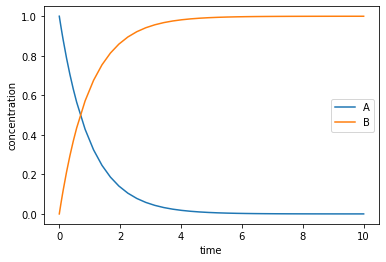

run time: 0.018s


In [2]:
chem = models.Chemistry()
chem.reaction('A=>B')
chem.initial_concentrations(A=1)
chem.time_stop=10
chem.run()

Rate constant:
$$
k = A e^{-E_a/RT}
$$

In [3]:
def k(A, Ea, T):
    return A*np.exp(-Ea/8.314/T)

choose correct temperature range for 0-th order rate approximation (method of initial rates):
$$ 
\ce{ [A] } = \ce{[A]0}-kt \\
k =  \frac{\ce{[A]0} - \ce{ [A] }}{t}
$$

In [4]:
@interact
def f(T=(700,1000,1),
     rt=(1,100)):
    chem.parameters[0]= k(A=np.exp(8.9), Ea=124195,T=T)
    chem.initial_concentrations(A=1)
    chem.time_stop=rt
    chem.run()
    print(chem.solution['B'][-1])

interactive(children=(IntSlider(value=850, description='T', max=1000, min=700), IntSlider(value=50, descriptio…

Define an experiment as a series of reactions at different temperatures with preset $E_a$, residence time, and $A$

In [5]:
def experiment(A=np.exp(8.9), Ea=124195, rt=1):

    conversions = np.array([])
    temps = np.arange(700,1000,25)
    for T in temps:
        chem.parameters[0]= k(A,Ea,T)
        chem.time_stop = rt
        chem.run(False)
        conversions = np.append(conversions, chem.solution['B'][-1])
    return temps, conversions

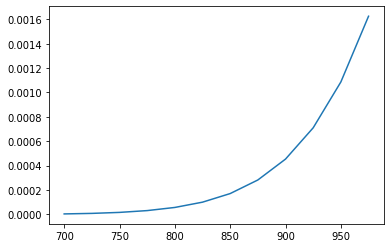

In [6]:
t, c = experiment()
p.plot(t,c)

Plotting Arrhenius plot alongside conversion profile.
$$ 
\ln{(k)} = \frac{-E_a}{RT} + \ln{(A)} \\
\ln{ \left( \frac{\ce{[A]0} - \ce{ [A] }}{t} \right) } = \frac{-E_a}{RT} + \ln{(A)}
$$

Text(0, 0.5, 'A')

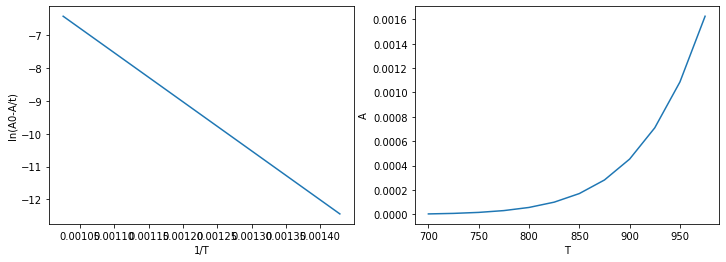

In [7]:
t, c = experiment(rt = 1, A=np.exp(8.9), Ea=124195)
f=p.figure(figsize=(12,4))
ax1 = p.subplot(1,2,1)
ax2 = p.subplot(1,2,2)
ax1.plot(1/t, np.log(c/chem.time_stop))
ax2.plot(t, c)
ax1.set_xlabel('1/T')
ax1.set_ylabel('ln(A0-A/t)')
ax2.set_xlabel('T')
ax2.set_ylabel('A')

Fitting Arrhenius law into 0-th order rate approximation.


Note, how fitted values differ from actual. Is this due to 0-th order approximation while reaction is really 1st order?

In [8]:
def find_params(t,c,rt):
    A=np.exp(8.9) 
    Ea=124195
    rt=1
    y = np.log(c/rt)
    x = 1/t
    to_fit = np.vstack([x,np.ones(len(x))]).T
    Ea_fit, lnA_fit = np.linalg.lstsq(to_fit,y, rcond=None)[0]
    A_fit=np.exp(lnA_fit)
    return f'Ea={-Ea_fit*8.31:1.3e}, A={A_fit:1.3e}'

find_params(t,c,rt=1)

'Ea=1.241e+05, A=7.313e+03'

Interactive mode:

In [9]:
data=[]
A=8.9
Ea=124195
@interact
def f(A = (A-5, A+5, 0.1), 
      Ea = (Ea-100000, Ea+100000, 10), 
      residence_time=(0.5 , 5, 0.1),
      order = (0.5,2,0.01)
     ):
    chem.orders = [[order, 0]]
    A = np.exp(A)
    t, c = experiment(A, Ea, rt = residence_time)
    #----plotting----
    f=p.figure(figsize=(12,4))
    ax1 = p.subplot(1,2,1)
    ax2 = p.subplot(1,2,2)
    data.append(list(c))
    ax1.plot(1/8.31/t, np.log((np.array(data[0]))/residence_time), 'r')
    ax2.plot(t, data[0], 'r')
    for i,y in enumerate(data[-10:][::-1]):
        ax1.plot(1/8.31/t, np.log((np.array(y))/residence_time), 'k', alpha=1-i/10)
        ax2.plot(t, y, 'k', alpha=1-i/10)
    ax1.set_xlabel('1/T')
    ax1.set_ylabel('ln(A/t)')
    ax2.set_xlabel('T')
    ax2.set_ylabel('A')
    f.suptitle('Fitted: '+ find_params(t,c,residence_time))

interactive(children=(FloatSlider(value=8.9, description='A', max=13.9, min=3.9000000000000004), IntSlider(val…